In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'retina'
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])

### Bertrand’s box paradox

$P(BB|B)=\frac{P(B|BB) \times P(BB)}{P(B|BB) \times P(BB)+P(B|BU) \times P(BU)+P(B|UU) \times P(UU)}=\frac{1 \times \frac{1}{3}}{1 \times \frac{1}{3} + \frac{1}{2} \times \frac{1}{3} + 0 \times \frac{1}{2}}=\frac{\frac{1}{3}}{\frac{1}{2}}=\frac{2}{3}$

#### Code 14.1

In [2]:
pancake = np.array([[1,1],[1,0],[0,0]])
# simulate a pancake and return randomly ordered sides
pancakes = np.asarray([np.random.permutation(pancake[np.random.choice(range(3))]) for i in range(10000)])
up = pancakes[:, 0]
down = pancakes[:, 1]
# compute proportion 1/1 (BB) out of all 1/1 and 1/0
num_11_10 = np.sum(up==1)
num_11 = np.sum((up==1) & (down==1))
num_11/num_11_10

0.6581248728899736

#### Code 14.2

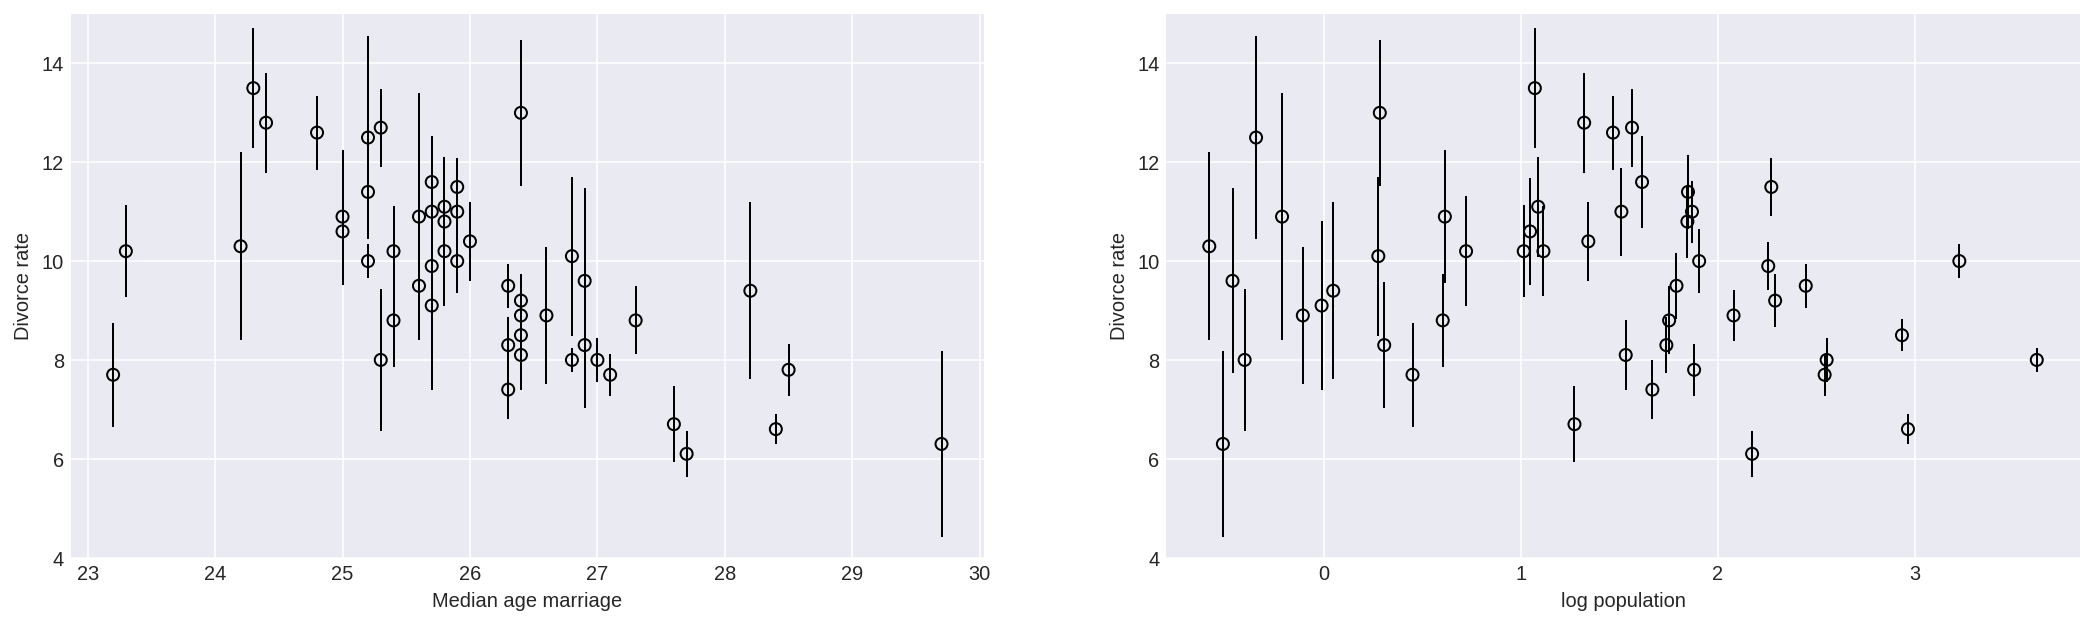

In [3]:
d = pd.read_csv('Data/WaffleDivorce.csv', ';')
d['log_population'] = np.log(d['Population'])

_, ax = plt.subplots(1, 2, figsize=(18, 5))

# points
ax[0].scatter(d['MedianAgeMarriage'], d['Divorce'], marker='o', facecolor='none', edgecolors='k', linewidth=1)
# standard errors
ax[0].errorbar(d['MedianAgeMarriage'], d['Divorce'], d['Divorce SE'].values, ls='none', color='k', linewidth=1)
ax[0].set_xlabel('Median age marriage')
ax[0].set_ylabel('Divorce rate')
ax[0].set_ylim(4, 15)

# points
ax[1].scatter(d['log_population'], d['Divorce'], marker='o', facecolor='none', edgecolors='k', linewidth=1)
# standard errors
ax[1].errorbar(d['log_population'], d['Divorce'], d['Divorce SE'].values, ls='none', color='k', linewidth=1)
ax[1].set_xlabel('log population')
ax[1].set_ylabel('Divorce rate')
ax[1].set_ylim(4, 15);

#### Code 14.3

In [4]:
div_obs = d['Divorce'].values
div_sd = d['Divorce SE'].values
R = d['Marriage'].values
A = d['MedianAgeMarriage'].values
N = len(d)

with pm.Model() as m_14_1:
    sigma = pm.HalfCauchy('sigma', 2.5)
    a = pm.Normal('a', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bR = pm.Normal('bR', 0., 10.)
    mu = a + bA*A + bR*R
    # this is the important bit, which wouldn't be here if
    # there was not measurement error. mu would have gone directly 
    # in the `obs` distribution
    div_est = pm.Normal('div_est', mu, sigma, shape=N)
    obs = pm.Normal('div_obs', div_est, div_sd, observed=div_obs)
    # start value and additional kwarg for NUTS
    start = dict(div_est=div_obs)
    trace_14_1 = pm.sample(4000, tune=1000, njobs=2, 
                           start=start, nuts_kwargs=dict(target_accept=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [div_est, bR, bA, a, sigma]
Sampling 2 chains: 100%|██████████| 10000/10000 [04:08<00:00, 40.21draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


#### Code 14.4

In [5]:
pm.summary(trace_14_1, varnames=['div_est', 'a', 'bA', 'bR', 'sigma']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
div_est__0,11.78,0.68,0.01,10.43,13.07,9138.19,1.0
div_est__1,11.21,1.05,0.01,9.26,13.45,10475.49,1.0
div_est__2,10.48,0.62,0.01,9.24,11.66,9609.09,1.0
div_est__3,12.33,0.87,0.01,10.64,14.03,11510.70,1.0
div_est__4,8.05,0.23,0.00,7.58,8.49,11256.30,1.0
div_est__5,11.02,0.73,0.01,9.58,12.44,9954.20,1.0
div_est__6,7.24,0.65,0.01,5.93,8.49,12084.30,1.0
div_est__7,9.36,0.91,0.01,7.59,11.11,11070.26,1.0
div_est__8,7.01,1.10,0.01,4.86,9.20,7136.50,1.0
div_est__9,8.54,0.30,0.00,7.92,9.10,12868.62,1.0


#### Code 14.5

In [6]:
div_obs = d['Divorce'].values
div_sd = d['Divorce SE'].values
mar_obs = d['Marriage'].values
mar_sd = d['Marriage SE'].values
A = d['MedianAgeMarriage'].values
N = len(d)

with pm.Model() as m_14_2:
    sigma = pm.HalfCauchy('sigma', 2.5)
    a = pm.Normal('a', 0., 10.)
    bA = pm.Normal('bA', 0., 10.)
    bR = pm.Normal('bR', 0., 10.)
    mar_est = pm.Flat('mar_est', shape=N)
    mu = a + bA*A + bR*mar_est
    div_est = pm.Normal('div_est', mu, sigma, shape=N)
    obs1 = pm.Normal('div_obs', div_est, div_sd, observed=div_obs)
    obs2 = pm.Normal('mar_obs', mar_est, mar_sd, observed=mar_obs)
    # start value and additional kwarg for NUTS
    start = dict(div_est=div_obs, mar_est=mar_obs)
    trace_14_2 = pm.sample(4000, tune=1000, njobs=3, 
                           start=start, nuts_kwargs=dict(target_accept=.95))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [div_est, mar_est, bR, bA, a, sigma]
Sampling 3 chains: 100%|██████████| 15000/15000 [06:56<00:00, 11.83draws/s]
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.


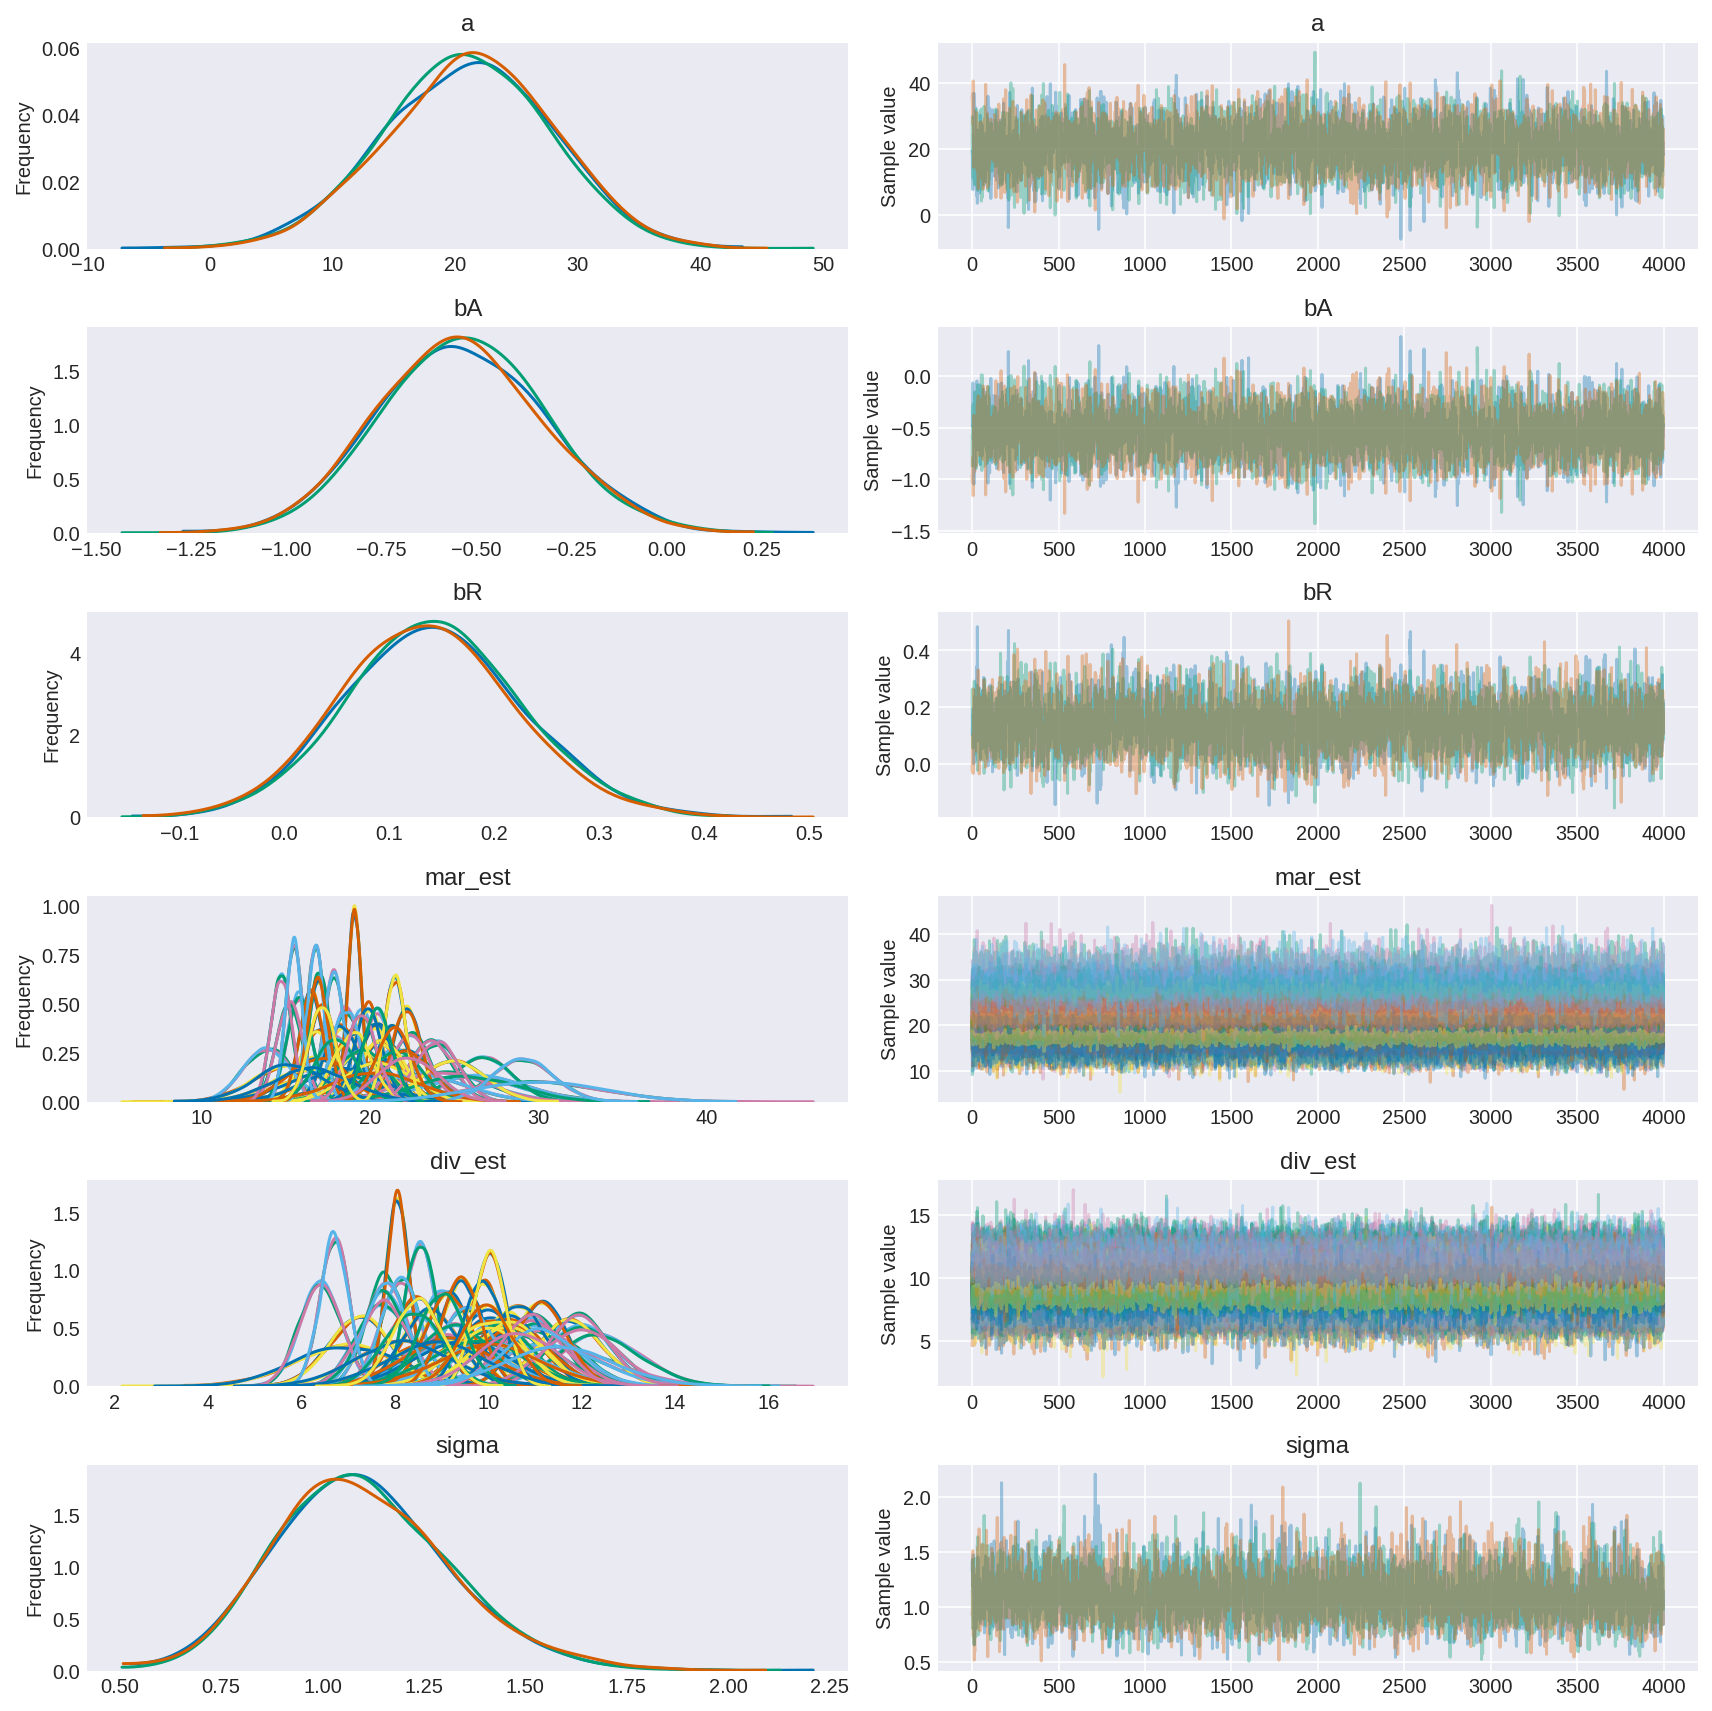

In [7]:
pm.traceplot(trace_14_2);

#### Code 14.6

In [8]:
d = pd.read_csv('Data/milk.csv', ';')
d.loc[:,'neocortex.prop'] = d['neocortex.perc'] / 100
d.loc[:,'logmass'] = np.log(d['mass'])

#### Code 14.7

In [9]:
# prep data
kcal = d['kcal.per.g'].values.copy()
logmass = d['logmass'].values.copy()
# PyMC3 can handle missing value quite naturally.
neocortex = d['neocortex.prop'].values.copy()
mask = np.isfinite(neocortex)
neocortex[~mask] = -999
neocortex = np.ma.masked_values(neocortex, value=-999)

In [10]:
# fit model
with pm.Model() as m_14_3:
    sigma = pm.HalfCauchy('sigma', 1.)
    sigma_N = pm.HalfCauchy('sigma_N', 1.)
    nu = pm.Normal('nu', .5, 1.)
    bN = pm.Normal('bN', 0., 10.)
    bM = pm.Normal('bM', 0., 10.)
    a = pm.Normal('a', 0., 100.)
    neocortex_ = pm.Normal('neocortex', nu, sigma_N, observed=neocortex)
    mu = a + bN*neocortex_ + bM*logmass
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    trace_14_3 = pm.sample(5000, tune=5000, njobs=2)

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/model.py:1266: UserWarning: Data in neocortex contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [neocortex_missing, a, bM, bN, nu, sigma_N, sigma]
Sampling 2 chains: 100%|██████████| 20000/20000 [03:39<00:00, 91.06draws/s] 
There were 90 divergences after tuning. Increase `target_accept` or reparameterize.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.
The acceptance probability does not match the target. It is 0.8942159947051597, but should be close to 0.8. Try to increase the number of tuning steps.
The number of effective samples is smaller than 25% for some parameters.


#### Code 14.8

In [11]:
# the missing value in pymc3 is automatically model as a node with *_missing as name
pm.summary(trace_14_3, varnames=['neocortex_missing', 
                                 'a', 'bN', 'bM', 'nu', 'sigma_N', 'sigma']).round(2)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
neocortex_missing__0,0.63,0.05,0.00,0.53,0.73,6251.34,1.0
neocortex_missing__1,0.62,0.05,0.00,0.53,0.73,4802.00,1.0
neocortex_missing__2,0.62,0.05,0.00,0.52,0.73,5286.11,1.0
neocortex_missing__3,0.65,0.05,0.00,0.56,0.75,5477.25,1.0
neocortex_missing__4,0.70,0.05,0.00,0.61,0.80,6494.64,1.0
neocortex_missing__5,0.66,0.05,0.00,0.56,0.76,8421.53,1.0
neocortex_missing__6,0.69,0.05,0.00,0.59,0.78,8922.86,1.0
neocortex_missing__7,0.70,0.05,0.00,0.60,0.79,6822.48,1.0
neocortex_missing__8,0.71,0.05,0.00,0.62,0.81,5807.21,1.0
neocortex_missing__9,0.65,0.05,0.00,0.55,0.74,8662.33,1.0


#### Code 14.9

In [12]:
# prep data
neocortex = np.copy(d['neocortex.prop'].values)
mask = np.isfinite(neocortex)
kcal = np.copy(d['kcal.per.g'].values[mask])
logmass = np.copy(d['logmass'].values[mask])
neocortex = neocortex[mask]

# fit model
with pm.Model() as m_14_3cc:
    sigma = pm.HalfCauchy('sigma', 1.)
    bN = pm.Normal('bN', 0., 10.)
    bM = pm.Normal('bM', 0., 10.)
    a = pm.Normal('a', 0., 100.)
    mu = a + bN*neocortex + bM*logmass
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    trace_14_3cc = pm.sample(5000, tune=5000, njobs=2)

pm.summary(trace_14_3cc, varnames=['a', 'bN', 'bM', 'sigma']).round(2)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [a, bM, bN, sigma]
Sampling 2 chains: 100%|██████████| 20000/20000 [01:50<00:00, 181.41draws/s]
There were 25 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
a,-1.08,0.56,0.01,-2.23,-0.01,2131.43,1.0
bN,2.78,0.87,0.02,1.10,4.55,2097.50,1.0
bM,-0.10,0.03,0.00,-0.15,-0.04,2514.79,1.0
sigma,0.14,0.03,0.00,0.09,0.20,1984.93,1.0


#### Code 14.10

In [13]:
# prep data
kcal = d['kcal.per.g'].values.copy()
logmass = d['logmass'].values.copy()
neocortex = d['neocortex.prop'].values.copy()
mask = np.isfinite(neocortex)
neocortex[~mask] = -999
neocortex = np.ma.masked_values(neocortex, value=-999)

with pm.Model() as m_14_4:
    sigma = pm.HalfCauchy('sigma', 1.)
    sigma_N = pm.HalfCauchy('sigma_N', 1.)
    a_N = pm.Normal('a_N', .5, 1.)
    betas = pm.Normal('bNbMgM', 0., 10., shape=3) # bN, bM, and gM
    a = pm.Normal('a', 0., 100.)
    
    nu = a_N + betas[2]*logmass
    neocortex_ = pm.Normal('neocortex', nu, sigma_N, observed=neocortex)
    
    mu = a + betas[0]*neocortex_ + betas[1]*logmass
    kcal_ = pm.Normal('kcal', mu, sigma, observed=kcal)
    
    trace_14_4 = pm.sample(5000, tune=5000, njobs=2)

pm.summary(trace_14_4, varnames=['neocortex_missing', 
                                 'a', 'bNbMgM', 'a_N', 'sigma_N', 'sigma']).round(2)

/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/pymc3/model.py:1266: UserWarning: Data in neocortex contains missing values and will be automatically imputed from the sampling distribution.
  warnings.warn(impute_message, UserWarning)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [neocortex_missing, a, bNbMgM, a_N, sigma_N, sigma]
Sampling 2 chains: 100%|██████████| 20000/20000 [03:38<00:00, 91.37draws/s] 
There were 173 divergences after tuning. Increase `target_accept` or reparameterize.
There were 12 divergences after tuning. Increase `target_accept` or reparameterize.
The number of effective samples is smaller than 25% for some parameters.


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
neocortex_missing__0,0.63,0.04,0.00,0.56,0.70,6063.39,1.0
neocortex_missing__1,0.63,0.04,0.00,0.55,0.70,6438.41,1.0
neocortex_missing__2,0.62,0.04,0.00,0.55,0.69,5232.51,1.0
neocortex_missing__3,0.65,0.03,0.00,0.58,0.71,8829.34,1.0
neocortex_missing__4,0.66,0.04,0.00,0.59,0.74,5588.99,1.0
neocortex_missing__5,0.63,0.04,0.00,0.56,0.70,7089.57,1.0
neocortex_missing__6,0.68,0.03,0.00,0.61,0.75,6833.04,1.0
neocortex_missing__7,0.70,0.03,0.00,0.63,0.77,8807.70,1.0
neocortex_missing__8,0.71,0.04,0.00,0.65,0.79,7975.82,1.0
neocortex_missing__9,0.66,0.04,0.00,0.59,0.73,7682.12,1.0


#### Code 14.11-14
Stan related. As you can see above, PyMC3 deal with missing value internally if you represent the observed data using a numpy mask array. The missing/masked value are replaced with a new random variable added to the model (with name `*_missing`).

In [14]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was createad on a computer %s running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\n" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__))

This notebook was createad on a computer x86_64 running debian stretch/sid and using:
Python 3.7.2
IPython 7.6.1
PyMC3 3.6
NumPy 1.16.0
SciPy 1.2.0
Matplotlib 3.0.2



/home/damianos/.conda/envs/statRethinkPymc3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DeprecationWarning: dist() and linux_distribution() functions are deprecated in Python 3.5
  
